# library

In [2]:
import warnings
warnings.filterwarnings('ignore')

import gc

import fastai
import seaborn as sns

from fastai import *

from torch.nn.init import kaiming_normal_

from fastai.datasets import *
from fastai.tabular import *
from fastai.basic_data import *

from sklearn.model_selection import train_test_split

import pandas as pd

from fastai.basic_train import *

import pdb

from pathlib import Path

from fastai.callbacks import *
from fastai.metrics import *

import numpy as np

from matplotlib.mlab import griddata

from fastai.text import *

from tabint.feature import *                         

In [ ]:
def numpy_sample(arr, n_sample, axis=0):
    if n_sample > arr.shape[axis]: n_sample = arr.shape[axis]
    mask = np.random.permutation(np.array(list(range(n_sample))))
    
    if axis == 0: 
        if len(arr.shape) == 1: return arr[mask]
        elif len(arr.shape) == 2: return arr[mask,:]
        elif len(arr.shape) == 3: return arr[mask,:,:]
    elif axis == 1: 
        if len(arr.shape) == 2: return arr[:,mask,:]
        elif len(arr.shape) == 3: return arr[:,mask,:]
    elif axis == 2: return arr[:,:,mask]   

# read data

In [63]:
#data.to_pickle('telco.pkl')
telco = pd.read_pickle('telco.pkl')

In [64]:
y = telco['churn'].copy()

In [65]:
telco.drop('churn', axis = 1, inplace=True)

In [85]:
x_train, x_val, y_train_class, y_val_class = train_test_split(telco, y, test_size=0.2, stratify = y)

In [93]:
del telco

## features list

In [427]:
features_origin = x_train.columns

In [888]:
features = ['sum_total_use_charge', 'sum_total_A s', 'sum_free_service_fee', 
'sum_t_A_charge', 'sum_t_dịch vụ B_charge', 'sum_t_dịch vụ B_times',
 'sum_t_A_times', 'sum_total_use_A s', 'sum_t_A_duration', 'sum_D_other_charge', 
 'sum_C_charge', 'sum_C_times', 'sum_E_times', 'sum_E_duration', 'sum_F_times', 'sum_F_charge', 'sum_E_charge', 
'sum_G_times', 'sum_G_duration', 'sum_G_charge', 'sum_H_times', 'sum_H_charge', 'sum_M_volume', 'sum_M_times', 'sum_M_charge']

In [485]:
meaning = ['Tổng tiền sử dụng tất cả cácdịch vụ',
    'Tổng số lần sử dụng dịch vụ', 
    'Phí tham gia  free_service',
    'Tổng phí dv A ',
    'Tổng phí dịch vụ B',
    'Tổng số dịch vụ B',
    'Tổng số lần sử dụng dịch vụ A (bao gồm cả có phí vs miễn phí)',
    'Tổng số lần sử dụng dịch vụ A (có phí)',
    'Tổng thời lượng sử dụngdịch vụ A',
    'Phí dịch vụ D',
    'Tổng phí C',
    'Tổng số lần đăng ký C',
    'Tổng số lần sử dụng dịch vụ E',
    'Tổng thời gian sử dụng dịch vụ E',
    'Tổng số lần sử dụng dịch vụ F',
    'Tổng phí dịch vụ F',
    'Tổng phí dịch vụ E',
    'Tổng số lần sử dụng dịch vụ G',
    'Tổng thời gian sử dụng dịch vụ G',
    'Tổng phí dịch vụ G',
    'Tổng số lần sử dụng dịch vụ H',
    'Tổng phí dịch vụ H',
    'Tổng lượng hàng đã mua của dịch vụ M',
    'Tổng số lần sử dụng M',
    'Tổng phí sử dụng M']

In [889]:
meaning = ['tiền sd tất cả các dv',
    'số lần sd dv', 
    'Phí tham gia free_service',
    'phí dv A ',
    'phí dv B',
    'số dv B',
    'số lần sd dv A (có phí & miễn phí)',
    'số lần sd dv A (có phí)',
    'thời lượng sddv A',
    'Phí dv D',
    'phí C',
    'số lần đk C',
    'số lần sd dv E',
    'tg sd dv E',
    'số lần sd dv F',
    'phí dv F',
    'phí dv E',
    'số lần sd dv G',
    'tg sd dv G',
    'phí dv G',
    'số lần sd dv H',
    'phí dv H',
    'lượng hàng đã mua của dv M',
    'số lần sd M',
    'phí sd M']

In [890]:
features_dict = {}
for f,m in zip(features, meaning):
    features_dict[f] = {}
    features_dict[f]['origin'] = [i for i in features_origin if i.startswith(f)]
    features_dict[f]['meaning'] = m

In [431]:
f2i = {f:i for i,f in enumerate(features)}

## sample

In [86]:
x_train = x_train[:100].copy()
y_train_class = y_train_class[:100]

In [87]:
x_val = x_val[:100].copy()
y_val_class = y_val_class[:100]

## normalize

In [88]:
maxmin = x_train.max() - x_train.min() +1

In [89]:
mean = x_train.mean()

In [360]:
np.mean(x_train[features_dict['sum_total_use_charge']['origin']].values) + 1

1.0

In [362]:
for f in features:
    columns = features_dict[f]['origin']
    #train    
    mean = np.mean(x_train[columns].values)
    features_dict[f]['mean_train'] = mean
    
    std = np.std(x_train[columns].values) + 1
    features_dict[f]['std_train'] = std
    
    x_train[columns] = (x_train[columns] - mean)/std
    
    #val
    mean = np.mean(x_val[columns].values)
    features_dict[f]['mean_val'] = mean
    
    std = np.std(x_val[columns].values) + 1
    features_dict[f]['std_val'] = std
    
    x_val[columns] = (x_val[columns] - mean)/std

# architechture

## RNN core

In [859]:
class encoder(nn.Module):
    "AWD-LSTM/QRNN inspired by https://arxiv.org/abs/1708.02182."
    def __init__(self, input_sz,hidden_sz, n_rnn, 
                 hidden_drp=0.2, input_drp=0.6, weight_drp=0.5,
                 att_seq_drp = 0.2, att_fea_drp = 0.3, output_drp = 0.2, tp = 'behavior'):

        super().__init__()
        self.tp = tp
        self.hidden_sz,self.n_rnn = hidden_sz,n_rnn
        
        self.input_drps = RNNDropout(input_drp)
        self.hidden_drps = nn.ModuleList([RNNDropout(hidden_drp) for l in range(n_rnn)])
        self.output_dp = RNNDropout(output_drp)
        
        self.rnns = [nn.LSTM(input_sz if l == 0 else hidden_sz, hidden_sz, 1, batch_first = True) for l in range(n_rnn)]
        self.rnns = [WeightDropout(rnn, weight_drp) for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)        
        
        self.att_seq = attention_block(input_sz = input_sz, hidden_sz = hidden_sz, tp = 'seq')
        self.att_fea = attention_block(input_sz = input_sz, hidden_sz = hidden_sz, tp = 'fea')

    def forward(self, input):
        raw_output = self.input_drps(input)        
        hiddens_states,cells_states,raw_outputs,outputs = [],[],[],[]
        for l, (rnn,hidden_drp) in enumerate(zip(self.rnns, self.hidden_drps)):
            raw_output, (hidden_state, cell_state) = rnn(raw_output.float())
            hiddens_states.append(hidden_state); cells_states.append(cell_state); raw_outputs.append(raw_output)
            if l != self.n_rnn - 1: raw_output = hidden_drp(raw_output)
            outputs.append(raw_output)
        
        output = self.output_dp(outputs[-1])
        last_output = output[:,-1,:]
        att_seq, att_seq_m = self.att_seq(input, hidden_state)
        att_fea, att_fea_m = self.att_fea(input, hidden_state)
        
        return last_output, att_seq, att_seq_m, att_fea, att_fea_m

## decoder

In [689]:
class linear_block(nn.Module):
    def __init__(self, ip_sz, op_sz, drop = None, bias = True, initrange = None):
        super().__init__()
        self.op_sz = op_sz
        self.ln = nn.Linear(ip_sz, op_sz, bias = bias)
        kaiming_normal_(self.ln.weight.data)
        if initrange is not None: self.ln.weight.data.uniform_(-initrange, initrange)
        if bias: self.ln.bias.data.zero_()
        if drop is not None:
            self.bn = nn.BatchNorm1d(op_sz)
            self.drp = nn.Dropout(drop)
        else: self.drp = None
        
    def forward(self, x):
        x = x.float()
        x = self.ln(x) if self.drp is None else F.relu(self.drp(self.bn(self.ln(x))))
        return x

In [858]:
class decoder(nn.Module):
    initrange=0.1
    def __init__(self, input_sz, hidden_sz, decode_drps, bias=True, tp = 'behavior'):
        super().__init__()
        self.tp = tp
        layer_list = [hidden_sz + input_sz*2, 64, 32, 25 if tp == 'behavior' else 1]
        decode_drps = decode_drps + [None]
        self.ln_modules = nn.ModuleList([linear_block(layer_list[i], layer_list[i+1], drop=decode_drps[i]) for i in range(len(layer_list)-1)])

    def forward(self, input):
        last_output, att_seq, att_seq_m, att_fea, att_fea_m = input        
        x = torch.cat([last_output, att_seq, att_fea], 1)        
        for lyer in self.ln_modules: x = lyer(x)
        
        return x.float() if self.tp == 'behavior' else (x.view(-1), att_seq_m, att_fea_m)

## attention

In [877]:
class attention_block(nn.Module):
    def __init__(self, input_sz = 64, hidden_sz = 64, tp = 'fea'):
        super().__init__()
        self.tp = tp
        #self.w = self.rand_p(ip_sz, op_sz)
        self.ln_h = linear_block(hidden_sz, input_sz)
        self.ln_i = linear_block(input_sz, input_sz)
        self.v = self.rand_p(input_sz, input_sz)
    
    @staticmethod
    def rand_p(*sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))
              
    def forward(self, inpt, hidden):
        wh = self.ln_h(hidden.permute(1,0,2))
        wi = self.ln_i(inpt) #outp@self.w
        u = torch.tanh(wh + wi)
        if self.tp == 'fea':
            att = F.softmax((u@self.v).sum(1), 1)
            weighted = att.double()*inpt.sum(1).double()
        elif self.tp == 'seq':
            att = F.softmax(u@self.v, 1)
            weighted = (att.double()*inpt.double()).sum(1)
        return weighted.float(), att

# dataset

In [101]:
class telcodataset(DatasetBase):
    def __init__(self, x, y):
        self.x = x
        self.y = np.float32(y)
    
    def __len__(self)->int: return len(self.y)
    def __getitem__(self, idx): return self.x[:,idx,:], self.y[idx]
    
    @property
    def c(self)->int: 25

In [102]:
class telcodatabunch(DataBunch):
    "Create a `DataBunch` suitable for tabular data."
    @classmethod
    def from_df(cls, path, x_train, y_train, x_val, y_val, **kwargs):
        "Create a `DataBunch` from train/valid/test dataframes."
        train_ds = telcodataset(x_train, y_train)
        valid_ds = telcodataset(x_val, y_val)
        datasets = [train_ds, valid_ds]
        return cls.create(*datasets, path=path, **kwargs)

# learner

In [595]:
def split_func(model):
    "Split a RNN `model` in groups for differential learning rates."
    groups = [model[0].input_drps]
    groups = [[rnn, dp] for rnn, dp in zip(model[0].rnns, model[0].hidden_drps)]
    groups.append([model[0].att_seq, model[0].att_fea, model[1]])
    return groups

In [596]:
class RNNLearner(Learner):
    "Basic class for a Learner in RNN."
    def __init__(self, path, data, model, clip=None, adjust=False, alpha=2,beta=1, **kwargs):
        super().__init__(data, model, path = path, model_dir = 'models', **kwargs)
        self.path = path
        if clip: self.callback_fns.append(partial(GradientClipping, clip=clip))
        if split_func: self.split(split_func)
        self.metrics = None 
        
    def predict_from_np(self, x, return_att = True, batch_first = False):
        self.model.eval()
        if not batch_first: x = np.transpose(x, (1,0,2))
        x = Tensor(x)
        pred, att_seq, att_fea = self.model(x)
        pred = to_np(torch.sigmoid(pred))
        if return_att: return pred, to_np(att_seq), to_np(att_fea)
        else: return pred
    
    def save_encoder(self, name:str):
        torch.save(self.model[0].state_dict(), self.path/f'{name}.pth')

    def load_encoder(self, name:str):
        self.model[0].load_state_dict(torch.load(self.path/f'{name}.pth'))
        self.freeze()
    
    @classmethod
    def creat_model(cls, path, data, 
                    input_sz, hidden_sz, n_rnn, drop_mult,
                    att_seq_drp, att_fea_drp, output_drp,
                    decode_drps, bias = True, tp = 'behavior', **kwargs):
        dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * drop_mult
        
        rnn_enc = encoder(input_sz=input_sz, hidden_sz=hidden_sz, n_rnn=n_rnn, 
                          input_drp=dps[0], weight_drp=dps[2], hidden_drp=dps[4],
                          att_seq_drp = 0.2, att_fea_drp = 0.3, output_drp = 0.2)
        
        lnr_dec = decoder(input_sz = input_sz, hidden_sz = hidden_sz, 
                          decode_drps = decode_drps, bias= bias,  tp = tp)
        
        model = SequentialRNN(rnn_enc, lnr_dec)
        return cls(path, data, model, **kwargs)

# behavior model

## dataloader

In [105]:
tn = [t for t in features_origin if t.endswith('tn')]
tn_1 = [t for t in features_origin if t.endswith('tn_1')]
tn_2 = [t for t in features_origin if t.endswith('tn_2')]
tn_3 = [t for t in features_origin if t.endswith('tn_3')]
tn_4 = [t for t in features_origin if t.endswith('tn_4')]
tn_5 = [t for t in features_origin if t.endswith('tn_5')]

In [106]:
x_train_behave = np.stack([x_train[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1]])
x_val_behave = np.stack([x_val[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1]])
y_train_behave = np.stack([x_train[tn]])[0]
y_val_behave = np.stack([x_val[tn]])[0]

In [680]:
db = telcodatabunch.from_df('/', x_train_behave, y_train_behave, x_val_behave, y_val_behave, bs = 16)

## learner

In [692]:
learner = RNNLearner.creat_model(Path('./models'), db, input_sz = 25, hidden_sz = 8, n_rnn = 3, drop_mult = 0.5, 
                                 att_seq_drp = 0.2, att_fea_drp=0.2, output_drp=0.1,
                                 decode_drps = [0.2,0.3], tp = 'behavior' )

In [693]:
def loss(input, target):
    input = input.float(); target = target.float()
    return F.mse_loss(input, target, reduction='sum')

In [694]:
learner.loss_func = loss

In [695]:
learner.metrics = None

In [697]:
learner.fit_one_cycle(4)

Total time: 00:04
epoch  train_loss  valid_loss
1      87.662308   38.387684   (00:01)
2      77.582954   35.848156   (00:01)
3      69.016724   29.976238   (00:01)
4      63.072796   29.457331   (00:01)



In [123]:
learner.save_encoder('behavior_model')

# classifier

## dataset

In [703]:
x_train_class = np.stack([x_train[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1, tn]])
x_val_class = np.stack([x_val[t] for t in [tn_5, tn_4, tn_3, tn_2, tn_1, tn]])

In [704]:
db = telcodatabunch.from_df('/', x_train_class, y_train_class, x_val_class, y_val_class, bs = 16)

## learner

In [878]:
learner = RNNLearner.creat_model(Path('./models'), db, input_sz = 25, hidden_sz = 8, n_rnn = 3, drop_mult = 0.5, 
                                 att_seq_drp = 0.2, att_fea_drp=0.2, output_drp=0.1,
                                 decode_drps = [0.2,0.3], tp = 'classifier')

In [879]:
def loss(input, target):
    input, att_seq_m, att_fea_m = input
    input = input.float(); target = target.float()
    #imbalance
    return F.binary_cross_entropy_with_logits(input, target, reduction='sum', weight=target*0.6+0.2)

In [880]:
learner.loss_func = loss

In [881]:
learner.metrics = None

In [882]:
learner.fit_one_cycle(5)

Total time: 00:07
epoch  train_loss  valid_loss
1      2.653504    4.604403    (00:01)
2      2.559026    4.450950    (00:01)
3      2.372982    4.229383    (00:01)
4      2.239862    4.129299    (00:01)
5      2.138306    4.206190    (00:01)



# feature correlation

In [710]:
reshaped = np.transpose(x_train_class, (2, 1, 0)).reshape((25, -1))

In [711]:
ddg = Dendogram.from_series(features, reshaped)

values array is tranposed


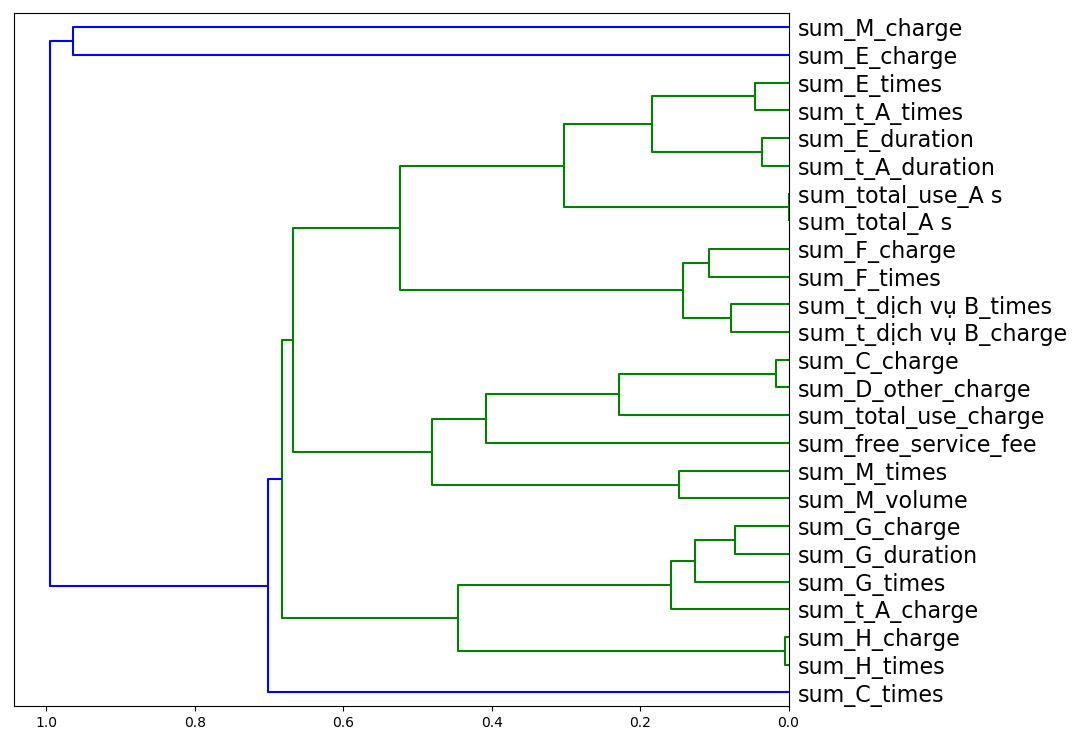

In [712]:
ddg.plot()

In [713]:
group_features = [['sum_total_use_A s','sum_total_A s'], ['sum_H_charge', 'sum_H_times']]
group_features = group_features + [i for i in features if i not in flat_list(group_features)]

# permutation importance

## feature importance

In [714]:
valx = db.valid_ds.x
valy = db.valid_ds.y

In [715]:
y_pred = learner.predict_from_np(valx, False)

In [725]:
baseline = roc_auc_score(valy, y_pred) 
ft_name, ft_impt = [], []
for gf in group_features:
    val_permute = val
    for f in to_iter(gf):
        i = f2i[f]        
        val_permute[:,:,i:i+1] = np.random.permutation(val_permute[:,:,i:i+1])
    y_permute = learner.predict_from_np(val_permute, False)
    score_permute = roc_auc_score(valy, y_permute) 
    ft_name.append(' & '.join(to_iter(gf)))
    ft_impt.append(baseline - score_permute)

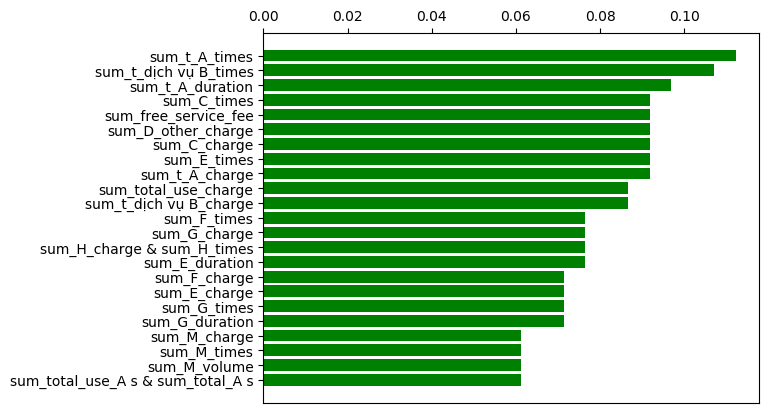

In [726]:
plot_barh_from_series(ft_name, ft_impt)

## sequence importance

In [727]:
time_range = list(range(-len(att_seq[1])+1, 1))

In [728]:
time_range_name = [str(i) for i in time_range]

In [729]:
seq_impt = []
for i in range(6):
    val_permute = val
    val_permute[:,i:i+1,:] = np.random.permutation(val_permute[:,i:i+1,:])
    y_permute = learner.predict_from_np(val_permute, False)
    score_permute = roc_auc_score(valy, y_permute)
    seq_impt.append(baseline - score_permute)

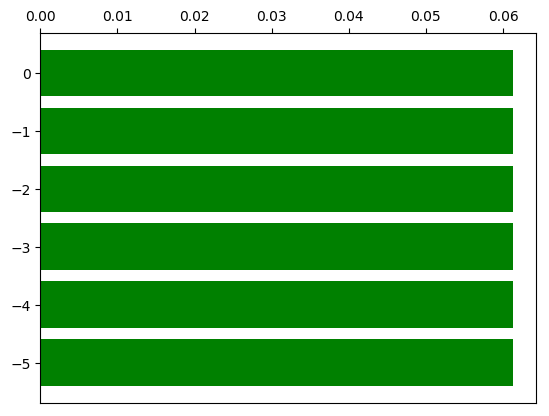

In [730]:
plot_barh_from_series(time_range, seq_impt)

# partial dependence

In [873]:
time_range = list(range(-len(att_seq[1])+1, 1))

In [874]:
x_transpose = np.transpose(valx, (1, 0, 2))

In [875]:
num_record = valx.shape[0]
num_space = 100

In [894]:
fmt = lambda x: "{:.2f}".format(x)

/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


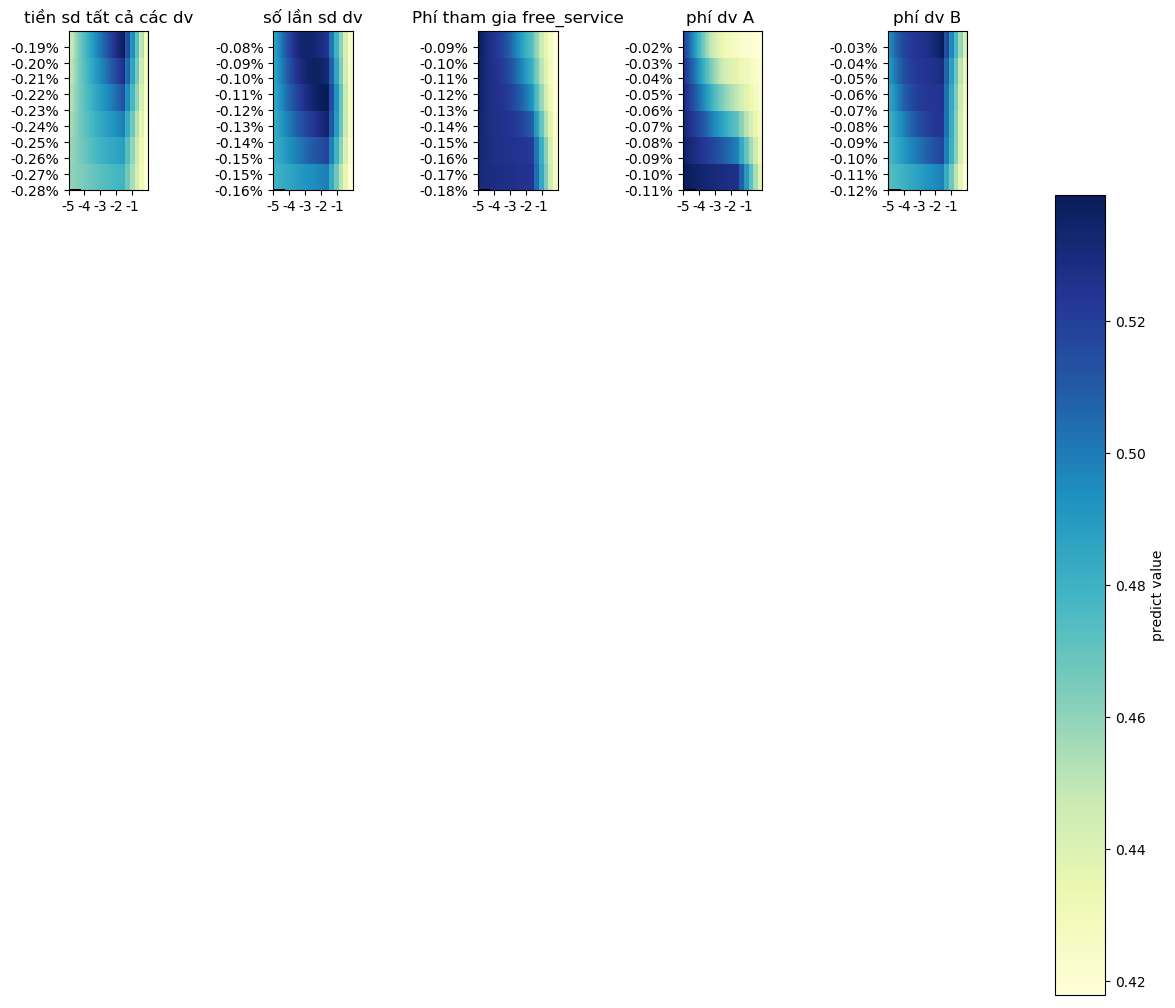

In [896]:
fig = plt.figure(figsize=(10,10))

for f, feature in enumerate(features):
    Max = np.max(x_transpose[:,:,f:f+1])
    Min = np.min(x_transpose[:,:,f:f+1])
    x = np.linspace(Min, Max, num_space)
    X, Y = np.meshgrid(x, time_range)
    preds = []
    
    
    space = np.tile(x, x_transpose.shape[0])
    inp = np.concatenate([np.tile(np.array([i]), [num_space,1,1]) for i in x_transpose])
    for m, month in  enumerate(time_range):
        inp[:,m:m+1,f:f+1] = space[..., None, None]
        pred = learner.predict_from_np(inp, False, True)
        pred = [np.mean(pred[np.array([num_record*j+i for j in range(num_record)])]) for i in range(num_space)]
        preds.append(pred)
    preds = np.stack(preds)
    
    ax = fig.add_subplot(5, 5, f+1)
    ax.contourf(X, Y, preds, 20, colors='black')
    
    im = plt.imshow(preds, extent=[0, 5, 0, 10], origin='lower', cmap="YlGnBu")
    plt.xticks(list(range(5)), time_range)
    plt.yticks(list(range(10)), [fmt(i) for i in x])
    plt.title(features_dict[feature]['meaning'])
    if f>3: break

cbar_ax = fig.add_axes([1.05, 0, 0.05, 0.8])
fig.colorbar(im, format=ticker.FormatStrFormatter('%.2f'), cax=cbar_ax, label='predict value')

plt.tight_layout()
plt.show()

# shap force plot

https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail

https://link.springer.com/article/10.1007/s10115-013-0679-x

In [497]:
def plot_barh_from_series(features, series, figsize = None, absolute = False):
    if figsize is not None: plt.figure(figsize=figsize)
    if type(series) == list: series = np.array(series)
    change_xaxis_pos(True)
    
    if not absolute: 
        argsort = np.argsort(series)
        barh = plt.barh([features[i] for i in argsort], series[argsort],color='g')
        mask = series[argsort]<0
    else:
        series_absolute = np.abs(series)
        argsort = np.argsort(series_absolute)
        mask = (series[argsort]<0)[::-1]
        barh = plt.barh([a[s] for s in argsort], series_absolute[argsort], color='g')
    
    for i,m in enumerate(mask): 
        if m: barh[i].set_color('r')
    
    change_xaxis_pos(False)

In [789]:
instance = valx[:,1:2,:]

In [412]:
features_permute = np.array([np.random.permutation(i) for i in np.tile(np.array(list(range(25))),(24,1))])

In [421]:
shap_values = []
for i,f in enumerate(features):
    b1 = [np.concatenate([instance[:,:,:i+1],valx[:,j:j+1,fts[i+1:]]],axis=2) for j, fts in enumerate(features_permute)]
    b1 = np.concatenate(b1,axis=1)
    
    b2 = [np.concatenate([instance[:,:,:i],valx[:,j:j+1,fts[i:]]],axis=2) for j, fts in enumerate(features_permute)]
    b2 = np.concatenate(b2,axis=1)
    
    phi = np.sum(learner.predict_from_np(b1,False) - learner.predict_from_np(b2,False))/100
    shap_values.append(phi)

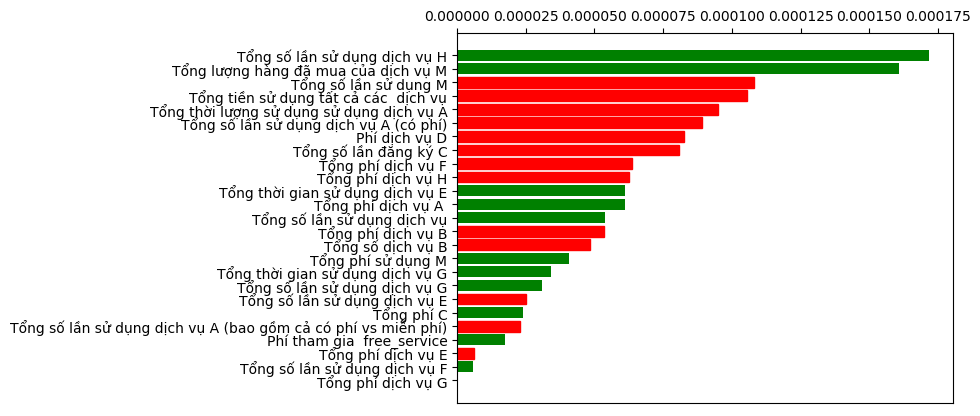

In [499]:
 plot_barh_from_series([features_dict[i]['meaning'] for i in features], shap_values, absolute=True)

# attention plot 

In [784]:
_, att_seq, att_fea = learner.predict_from_np(valx)

## attention feature


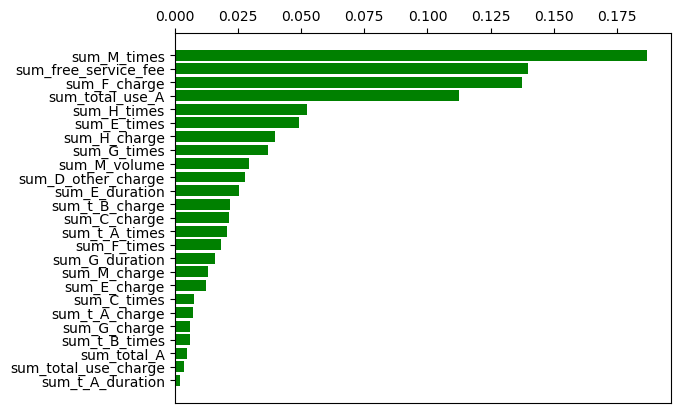

In [809]:
plot_barh_from_series(features, att_fea[1])

## attention and sequence

<Figure size 640x480 with 0 Axes>

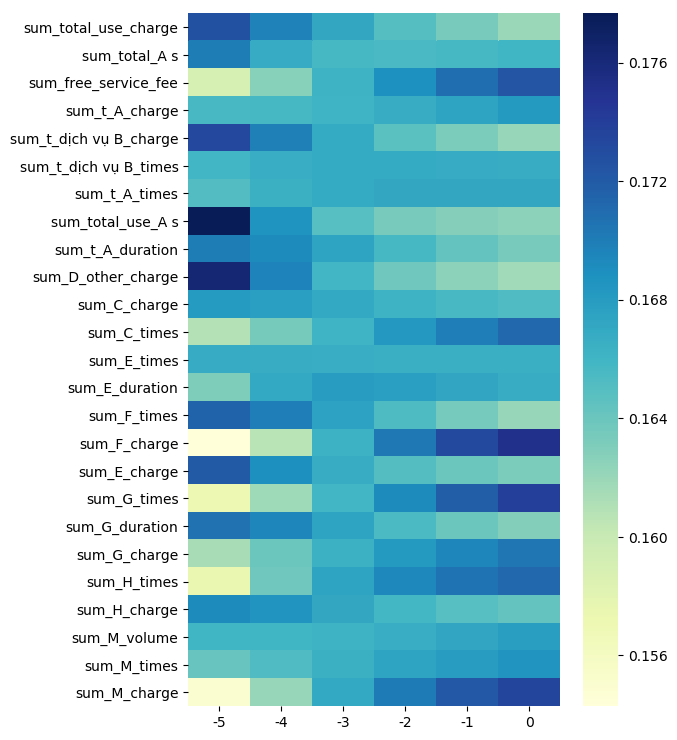

In [277]:
time_range = list(range(-len(att_seq[1])+1, 1))
plt.gcf().clear()
fig, ax = plt.subplots(figsize=(6,9))
ax = sns.heatmap(att_seq[1].T, xticklabels = time_range, yticklabels=features, cmap="YlGnBu")

## attention and values of variable

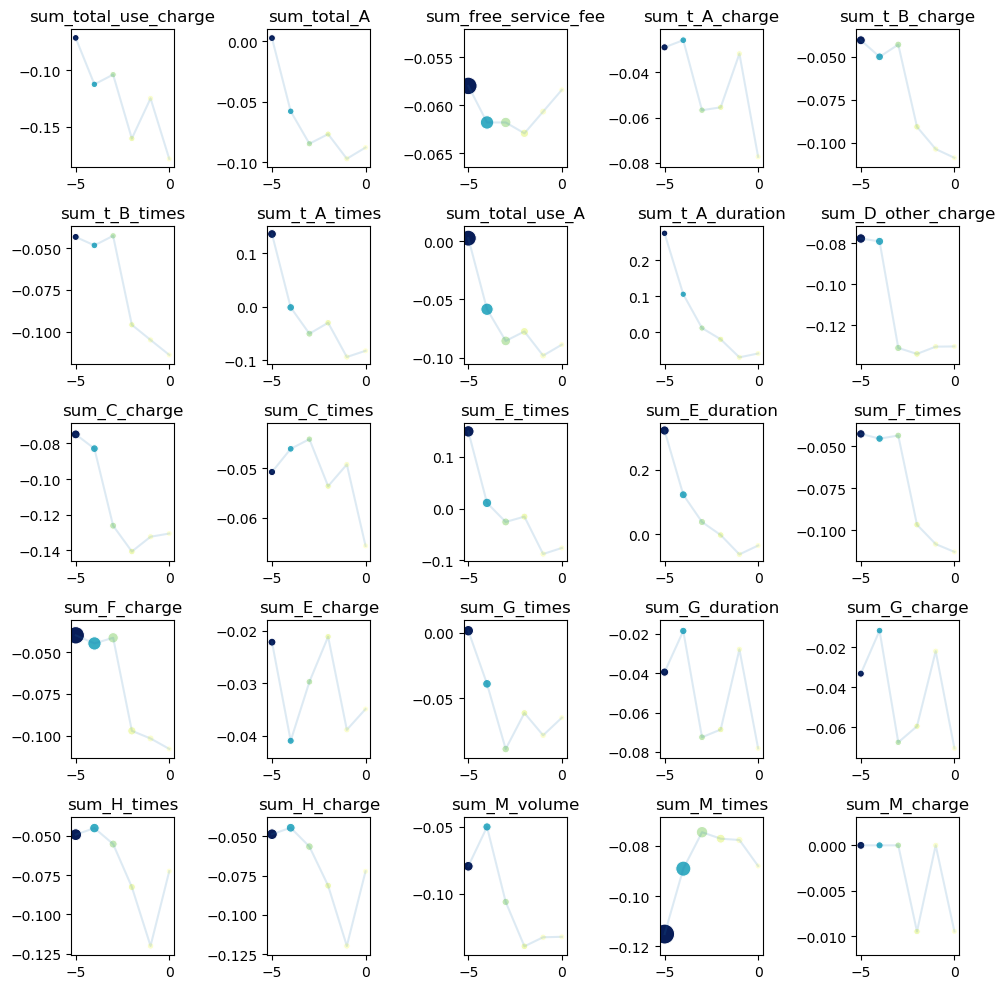

In [822]:
fig = plt.figure(figsize=(10,10))

num_record = 1
for f, feature in enumerate(features):
    ax = fig.add_subplot(5, 5, f+1)
    ax = sns.scatterplot(x=time_range, y=np.squeeze(instance[:,:,f]), 
                         hue=att_seq[1][:,1], size=att_seq[num_record][:,1], 
                         sizes=(20, 20 + 1000*att_fea[num_record][f]), 
                         legend = False, palette="YlGnBu")
    ax = sns.lineplot(x=time_range, y=np.squeeze(instance[:,:,f]), alpha = 0.15)
    plt.title(feature)
    
plt.tight_layout()
plt.show()